In [549]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
from torchinfo import summary
import matplotlib.pyplot as plt
%matplotlib inline

In [550]:
# ViT-Base hyper-parameters // 6
# layers: 2
# hidden size D: 128 
# MLP size: 512 (128x4)
# heads: 2

In [551]:
img_resolution = 32
batch_size = 4
patch_size = 8
embd_size = 128 # D model size
n_heads = 2
output_size = 10
epochs = 10
lr = 1e-3

In [552]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# CIFAR10 Dataset

In [553]:
# Data transform: tensor, normalize
transform = torchvision.transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [554]:
# Load cifar10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='cifar10-datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='cifar10-datasets', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [390]:
# Dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               shuffle=True, num_workers=4
                                              )
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                               shuffle=False, num_workers=4
                                              )

In [391]:
class_names = train_dataset.classes
dataset_size = {'train': len(train_dataset), 'test': len(test_dataset)}

In [392]:
def imshow(img, title=None):
    img = img.permute(1, 2, 0).numpy()
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)

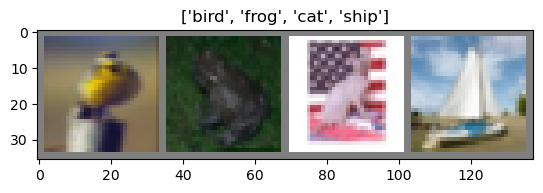

In [393]:
imgs, labels = next(iter(train_dataloader))
outs = torchvision.utils.make_grid(imgs)  
title = [class_names[l] for l in labels]
imshow(outs, title)

# Build Model
- Patch Embedding
- Positional Embedding
- Multi-Head Self Attention
- MLP
- Transformer Encoder Block
- ViT

# Patch Embedding

In [509]:
n_patches = int((img_resolution**2)/(patch_size**2)) # sequence length
assert img_resolution % patch_size == 0, "Image size must be divisible by patch size"

print(f"Image resolution: {img_resolution}")
print(f"Patch size: {patch_size}x{patch_size}")
print(f"Number of patches: {n_patches}")

Image resolution: 32
Patch size: 8x8
Number of patches: 16


In [449]:
def patch_imshow(img, img_resolution, patch_size, n_patches):
    img = img.permute(1, 2, 0).numpy()
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    fig, axs = plt.subplots(nrows = img_resolution // patch_size, 
                        ncols = img_resolution // patch_size,
                        figsize=(n_patches, n_patches),
                        sharex=True,
                        sharey=True
                      )
    
    for i, patch_height in enumerate(range(0, H, patch_size)):
        for j, patch_weidth in enumerate(range(0, W, patch_size)):
            img_patch = img[patch_height: patch_height+patch_size,
                                             patch_weidth: patch_weidth+patch_size,
                                             :]
            axs[i, j].imshow(img_patch)

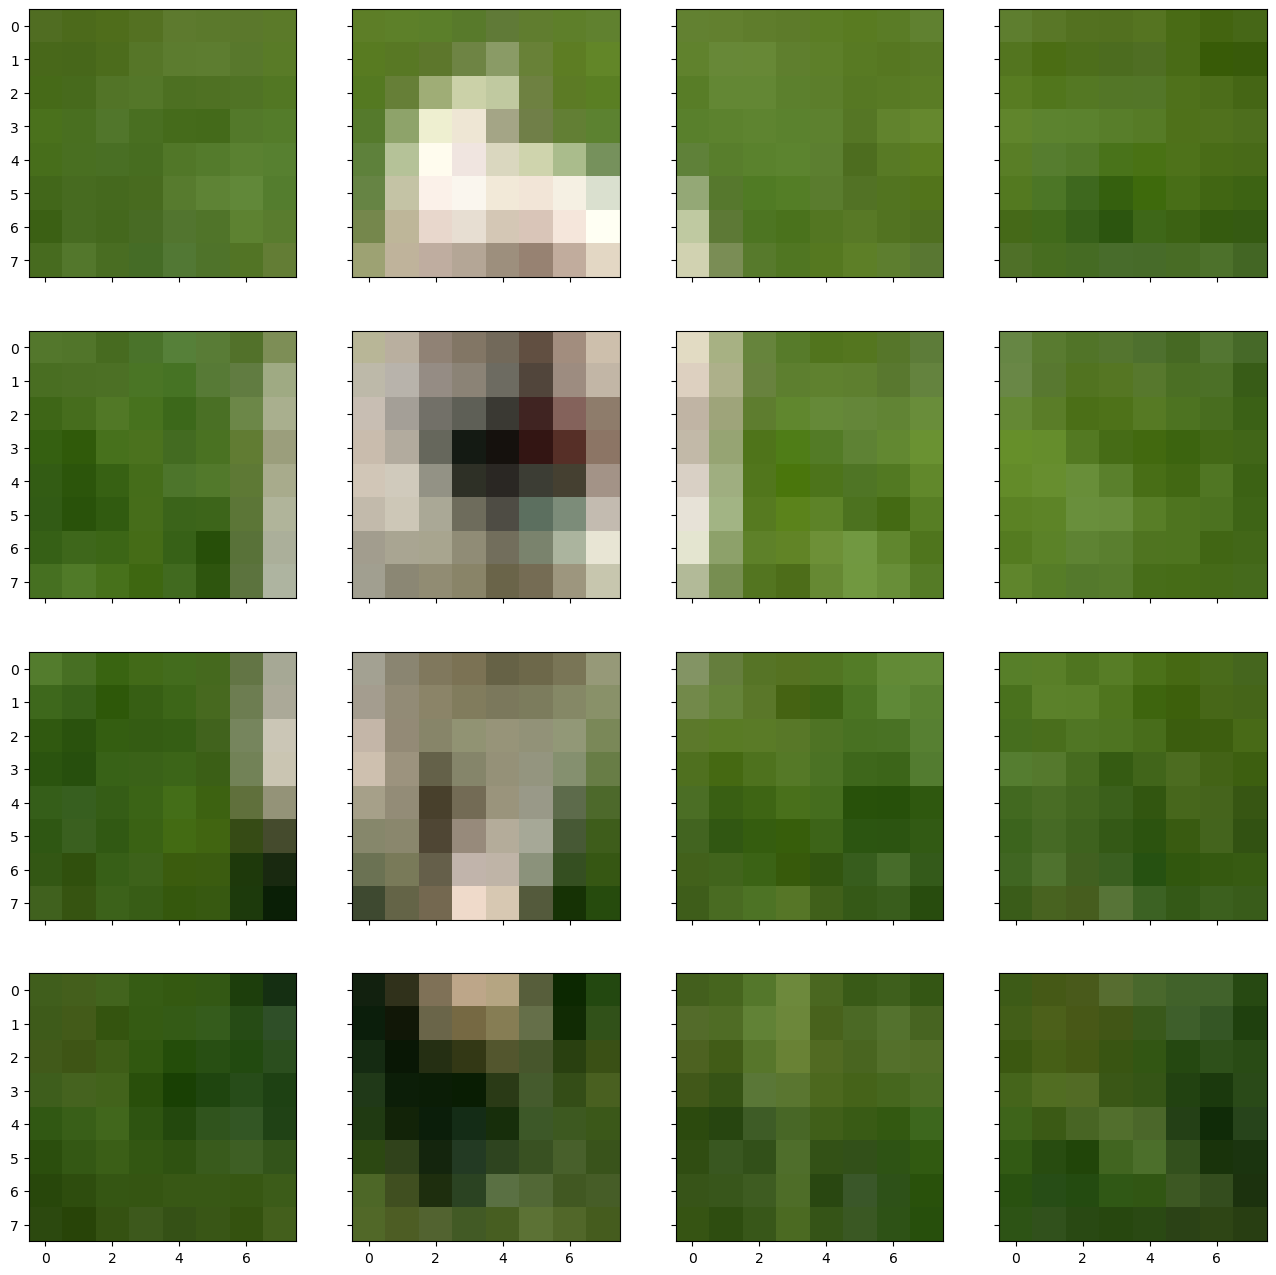

In [450]:
patch_imshow(img, img_resolution, patch_size, n_patches)

In [525]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, n_patches, embd_size):
        super().__init__()
        self.patch = nn.Conv2d(in_channels=in_channels, 
                               out_channels=embd_size,
                               kernel_size=patch_size,
                               stride=patch_size,
                               padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        self.class_token = nn.Parameter(torch.randn((1, 1, embd_size)), requires_grad=True) # (1, 1, D)
        self.position_embd = nn.Parameter(torch.randn((n_patches+1, embd_size)), requires_grad=True) # (N+1, D)
        
    def forward(self, x):
        x = x.unsqueeze(0) if x.dim() == 3 else x
        img_resolution = x.shape[-1]
        x = self.patch(x) # (B, D, P, P)
        x = self.flatten(x) # (B, N, D)
        x = x.permute(0, 2, 1)
        x = torch.cat((x, self.class_token.repeat(x.shape[0], 1, 1)), dim=1)
        x = x + self.position_embd
        return x

# Head

In [527]:
class Head(nn.Module):
    def __init__(self, embd_size, head_size):
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embd_size, head_size, bias=False)
        self.query = nn.Linear(embd_size, head_size, bias=False)
        self.value = nn.Linear(embd_size, head_size, bias=False)
        
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) 
        q = self.query(x) 
        a = q @ k.transpose(-2, -1) * self.head_size**-0.5
        
        v = self.value(x)
        out = a @ v
        return out

# Multi-Head Self Attention (MSA)

In [528]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, embd_size, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(embd_size, head_size) for _ in range(n_heads)])
        self.proj = nn.Linear(embd_size, embd_size) # projection back to residual pathway
        
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

# Multi-Layer Perceptron (MLP)

In [529]:
class MLP(nn.Module):
    def __init__(self, embd_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embd_size, 4 * embd_size),
            nn.GELU(),
        )
        self.proj = nn.Linear(4 * embd_size, embd_size) # projection back to residual pathway
    
    def forward(self, x):
        out = self.net(x)
        out = self.proj(out)
        return out

# Transformer Encoder Block

In [530]:
class EncoderBlock(nn.Module):
    def __init__(self, embd_size, n_heads):
        super().__init__()
        head_size = embd_size // n_heads
        self.sa_heads = MultiHeadAttention(n_heads, embd_size, head_size)
        self.mlp = MLP(embd_size)
        self.ln1 = nn.LayerNorm(embd_size)
        self.ln2 = nn.LayerNorm(embd_size)
        
    def forward(self, x):
        x = x + self.sa_heads(self.ln1(x)) # prenorm 
        x = x + self.mlp(self.ln2(x))
        return x

# Vision Transformer (ViT)

In [535]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embd = PatchEmbedding(in_channels=3, 
                                         patch_size=patch_size, 
                                         n_patches=n_patches,
                                         embd_size=embd_size)
        self.EncoderBlocks = nn.Sequential(
            EncoderBlock(embd_size, n_heads),
            EncoderBlock(embd_size, n_heads),
        )      
        self.classifier = nn.Sequential(
            nn.LayerNorm(embd_size),
            nn.Linear(embd_size, output_size)
        )    
        
    def forward(self, x):
        x = self.patch_embd(x)
        x = self.EncoderBlocks(x)
        x = self.classifier(x[:, 0, :])
        return x

In [536]:
summary(VisionTransformer(), 
        input_size=(1, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)         [1, 3, 32, 32]       [1, 10]              --                   True
├─PatchEmbedding (patch_embd)                 [1, 3, 32, 32]       [1, 17, 128]         2,304                True
│    └─Conv2d (patch)                         [1, 3, 32, 32]       [1, 128, 4, 4]       24,704               True
│    └─Flatten (flatten)                      [1, 128, 4, 4]       [1, 128, 16]         --                   --
├─Sequential (EncoderBlocks)                  [1, 17, 128]         [1, 17, 128]         --                   True
│    └─EncoderBlock (0)                       [1, 17, 128]         [1, 17, 128]         --                   True
│    │    └─LayerNorm (ln1)                   [1, 17, 128]         [1, 17, 128]         256                  True
│    │    └─MultiHeadAttention (sa_heads)     [1, 17, 128]         [1, 17, 128]      

# Model Training

In [570]:
torch.manual_seed(49)

model = VisionTransformer()
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [571]:
epoch_loss = 0.0
for inputs, labels in train_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    epoch_loss += loss
    
print(f"Loss @ init: {epoch_loss / len(train_dataloader):.4f}")

Loss @ init: 2.3753


In [572]:
def train(model, criterion, optimizer, dataloader, epochs):
    model.train()
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            logits = model(inputs)
            loss = criterion(logits, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss
        
        epoch_loss /= len(dataloader)
        print(f"Epoch: {epoch+1}/{epochs} | loss: {epoch_loss:.4f}")

In [573]:
train(model, criterion, optimizer, train_dataloader, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10 | loss: 1.8178
Epoch: 2/10 | loss: 1.6448
Epoch: 3/10 | loss: 1.5794
Epoch: 4/10 | loss: 1.5378
Epoch: 5/10 | loss: 1.5101
Epoch: 6/10 | loss: 1.4870
Epoch: 7/10 | loss: 1.4663
Epoch: 8/10 | loss: 1.4512
Epoch: 9/10 | loss: 1.4374
Epoch: 10/10 | loss: 1.4274


In [600]:
model.eval()
with torch.inference_mode():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs)
        probs = F.softmax(logits, dim=1)
        loss += -torch.log(probs[range(batch_size), labels]).sum() / batch_size

    loss /= len(test_dataloader)
    print(f'{loss:.4f}')

1.4153
